# Application of Support Vector Machines to classify orders with defected metres in textil B2B industry.

### Code and report developed by Javier Sáez for Textil Satanderina.

<img src=https://cersantander.com/wp-content/uploads/2014/12/Textil-Santanderina.png width=150 height=50 />

## Summary:
1. [Creation of our binary variable and the extraction of our data through our databases.](#id1)
1. [Data visualization.](#id2)
1. [Train/test partition.](#id3)
1. [Training our SVM model](#id4)
1. [Testing.](#id5)
1. [Conclusions.](#id6)

## 1. Creation of our binary variable and the extraction of our data through our databases.  <a name="id1"></a>

Before perform our data visualization and modeling we should process our data in order to take the information we need.

In [1]:
#general modules use to implement the SVM technic in this case, then you will be able to see other specific ones
#in the individual cell code
import pandas as pd
import openpyxl
import xlrd
import numpy as np
import glob
import matplotlib.pyplot as plt

We start opening our example data in order to load the columns in our future data frame ``df_defected_metres``.

In [2]:
data = pd.read_excel('C:/Users/Javier/Documents/GIT/Repositories/TFM-Textil-Santanderina/data/raw/ejemplo_datos.xlsx', engine='openpyxl')

For the shake of completeness we will use a little bit of our time to see how these columns look like, even though we will use only a few of these variables in the SVM techniqe. As we can see there are so many columns which will be not helpful at all in our model, we will pay pay special attention to the family of the article **(GrupoArticulo)**, the quantity **(Cantidad)** produced for satistying the bill **(Factura, 'F')**, the width of the textile porduct **(Ancho)** and the month of the year in which it was produced **(Fecha)**. These features will be part of our $X$ matrix.

Finally, as you could see in our last column we have the quantity of Defected Metres **(Metrosdefecutosos)** for each bill, we want to discretize it in order to become our binary $y$ column vector.

        Note that we could take into account other variables, but kernek techniques doesn't work that good with high-dimensional data. Also note that we printed three diferent tables of 11 columns due to the fact that we have 

In [3]:
data.iloc[:,0:11].head()

,TipoDoc,Documento,LineaDoc,Factura,LineaFra,Fecha,Cliente,PaisCliente,PaisDestino,Departamento,TipoOperacion
0,F,657453,1,657453,1,2020-01-24 00:00:00.000,999544,TN,TN,2,Venta
1,F,657454,1,657454,1,2020-01-24 00:00:00.000,999663,NL,PT,2,Venta
2,F,657455,1,657455,1,2020-01-24 00:00:00.000,999984,DE,DE,3,Venta
3,F,657455,2,657455,2,2020-01-24 00:00:00.000,999984,DE,DE,3,Venta
4,F,657455,3,657455,3,2020-01-24 00:00:00.000,999984,DE,DE,3,Venta


In [4]:
data.iloc[:,11:22].head()

,AfectaCantidad,Cantidad,Unidad,Precio,Moneda,Cambio,Importe,CodigoArticulo,GrupoArticulo,Serie,Acabado
0,1,5.0,Metros,0.0,EURO,1,0.0,114721,3,4421,2568
1,1,5.0,Metros,0.0,EURO,1,0.0,166468,2,40264,2783
2,1,1.0,Metros,0.0,EURO,1,0.0,164389,4,162835,0
3,1,1.0,Metros,0.0,EURO,1,0.0,165445,4,162835,0
4,1,1.0,Metros,0.0,EURO,1,0.0,165446,4,162835,0


In [5]:
data.iloc[:,23:32].head()

,Combinacion,Color,Ancho,CN8,Composicion,Lote,Pieza,MetroPieza,MetrosReducidos
0,0,0,145,58012200,1151,50-0404 / 001 R 01 2 2019,31,5.0,5.0
1,0,8196,145,52094900,1151,11-2193 / 000 4 2019,6,5.0,5.0
2,0,45531,160,55142200,3743,35-0121 / 001 2 2019,19,1.0,1.0
3,0,65141,160,55142200,3743,48-0114 / 001 2 2019,10,1.0,1.0
4,0,78666,160,55142200,3743,35-0123 / 001 2 2019,14,1.0,1.0


We obtain the info from 12 excels in our local directory for each month of the 2015 business year.

In [6]:
#we load the columns in our empty pandas data frame
df_defected_metres = pd.DataFrame(columns=data.columns)
#we point all the data related with the 2015 year
tablas20_ = glob.glob("C:/Users/Javier/Documents/GIT/Repositories/TFM-Textil-Santanderina/data/raw/2015*.xlsx")


for f in tablas20_:
    df = pd.read_excel(f, engine='openpyxl')
    #only bills('F') documents will have more than 0 in the defected metres column
    df_f = df.loc[df['TipoDoc'].isin(['F'])]
    #we drop the NaNs
    df_f = df_f.dropna()
    #we select only the rows (commercial invoices) in which we observe defected metres with the  != logical
    df_defects = df_f[df_f['MetrosDefectuosos']!=0]
    #finally we append those rows for each month
    df_defected_metres =  df_defected_metres.append(df_defects, ignore_index=True)
    #this print is just to checked that it works ! be careful if you try this it takes over 5 minutes
    print(df_defected_metres.shape)

(273, 33)
(857, 33)
(1647, 33)
(2887, 33)
(3381, 33)
(3802, 33)
(3950, 33)
(3988, 33)
(4323, 33)
(4883, 33)
(5406, 33)
(5473, 33)


We do the same in this case but adding observations with no deffects, we want 50-50 of each kind.

In [7]:
#same process as before
tablas20_ = glob.glob("C:/Users/Javier/Documents/GIT/Repositories/TFM-Textil-Santanderina/data/raw/2015*.xlsx")
for f in tablas20_:
    #same process as before
    df = pd.read_excel(f, engine='openpyxl')
    df_f = df.loc[df['TipoDoc'].isin(['F'])]
    df_f = df_f.dropna()
    #now we take the non-defected
    df_nodefects = df_f[df_f['MetrosDefectuosos']== 0]
    #and we take for each month 456 observations in order to have homogenous sample through time
    df_nodefects_random = df_nodefects.sample(n =456)
    df_defected_metres =  df_defected_metres.append(df_nodefects_random, ignore_index=True)
    #this print is just to checked that it works ! be careful if you try this it takes over 5 minutes
    print(df_defected_metres.shape)

(5929, 33)
(6385, 33)
(6841, 33)
(7297, 33)
(7753, 33)
(8209, 33)
(8665, 33)
(9121, 33)
(9577, 33)
(10033, 33)
(10489, 33)
(10945, 33)


Finally we create the binary variable, taking 1 as any value bigger than 0.

In [8]:
#discretizacion de la variable
df_defected_metres.loc[df_defected_metres.MetrosDefectuosos > 0,'MetrosDefectuosos'] = 1

Also would be interesting as well to obtain only the month from each observation with the intention to use it as a categorical variable when we create our model.

In [9]:
import datetime
year = df_defected_metres["Fecha"]
year = pd.to_datetime(year)
year = year.dt.month
#actually we shouldn't call this column of the data frame 'Fecha' because now it contains months
df_defected_metres['Fecha'] = year

## 2. Data visualization.<a name="id2"></a>

We will see now some plots which will confirm the features we choose for our Machine Learning model.
Let's start from the kind of product , we saw we have 12 different families. In the blue barplot we can see the distribution of the bills-lines related with productos with no deffects, and the red bars for the lines which already have deffected metres. 

At first instance we observe the our second family of fabrics tend to have deffects more than the others (in relation with the metres already produced).

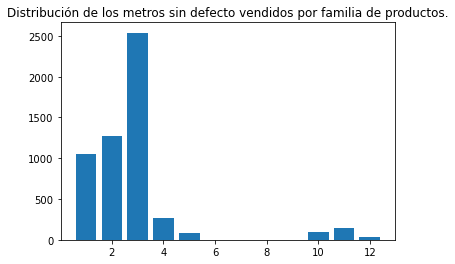

In [10]:
from matplotlib import pyplot
#we create an pd.Dataframe just for  the observations with 0 deffected metres
data_0 = df_defected_metres.loc[df_defected_metres['MetrosDefectuosos'] == 0]
non_defected = data_0.GrupoArticulo
non_defected = non_defected.astype("category")
(unicos, cuenta) = np.unique(non_defected, return_counts=True)
plot1 = plt.bar(x = unicos, height = cuenta)
titulo1 = plt.title("Distribución de los metros sin defecto vendidos por familia de productos.")

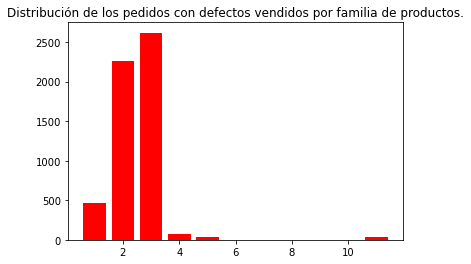

In [11]:
#same with the opposite case
data_1 = df_defected_metres.loc[df_defected_metres['MetrosDefectuosos'] == 1]
defected = data_1.GrupoArticulo
defected = defected.astype("category")
(unicos, cuenta) = np.unique(defected, return_counts=True)
plot2 = plt.bar(x = unicos, height = cuenta, color = 'red')
titulo2 = plt.title("Distribución de los pedidos con defectos vendidos por familia de productos.")

Surprisingly, the the order lines which actually have deffected metres have a lower median than the bills which have no deffects, so we see is not a problem about the demanded quantity, at first instance.

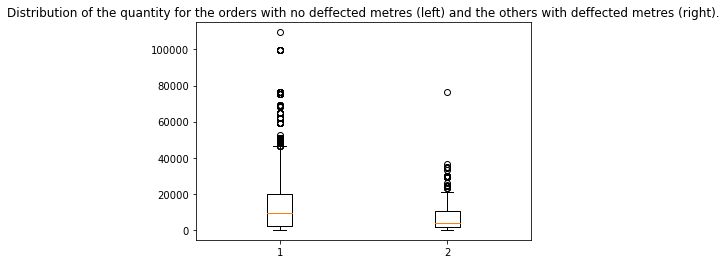

In [12]:
plot3 = plt.boxplot([data_0['Cantidad'],data_1['Cantidad']])
titulo3 = plt.title("Distribution of the quantity for the orders with no deffected metres (left) and the others with deffected metres (right).")

On the other hand, the orders with quality issues have a higer median withd.

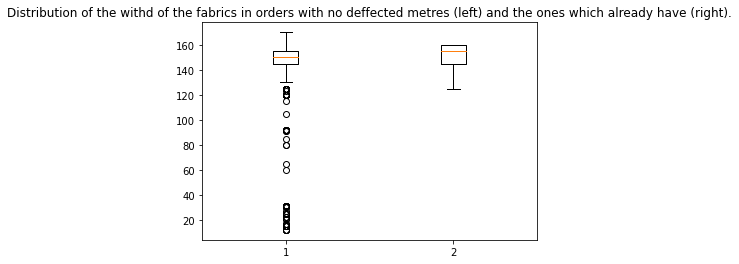

In [13]:
plot4 = plt.boxplot([data_0['Ancho'],data_1['Ancho']])
titulo4 = plt.title("Distribution of the withd of the fabrics in orders with no deffected metres (left) and the ones which already have (right).")

Finally, let's focus on a very interesting point, we see a cyciclal component on this. We observe a peak of the quality issues on abril, at least in the business year 2015.

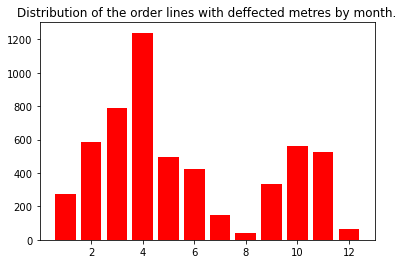

In [14]:
data_1 = df_defected_metres.loc[df_defected_metres['MetrosDefectuosos'] == 1]
defected = data_1.Fecha
defected = defected.astype("category")
(unicos, cuenta) = np.unique(defected, return_counts=True)
plot5 = plt.bar(x = unicos, height = cuenta, color = 'red')
titulo5 = plt.title("Distribution of the order lines with deffected metres by month.")

## 3. Train/test partition.<a name="id3"></a>

We need now to define our ``df``, let's only keep the four variables we mentioned before.

In [15]:
df = pd.DataFrame({'y': df_defected_metres.MetrosDefectuosos,'x1':df_defected_metres.GrupoArticulo,'x2':df_defected_metres.Ancho, 'x3':abs(df_defected_metres.Cantidad),
                  'x4':year})

Also it is needed to change few of them to categorical.

In [16]:
#in the case of the quantity and the width is not the case
df.y = df.y.astype('category')
df.x1 = df.x1.astype('category')
df.x4 = df.x4.astype('category')

Then we define our $X$ matrix of features and the vector column $y$, being them a vector with all the '1's and '0's associated to our goal variable.

In [17]:
X = df.iloc[:,1:]
y = df['y']

In [18]:
X.head()

,x1,x2,x3,x4
0,2,150,1584.5,1
1,2,150,1584.5,1
2,2,150,1584.5,1
3,2,150,1584.5,1
4,2,150,1584.5,1


Finally we use ``train_test_split`` command from the sklearn library to make our train/test split.

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0)

We have a train sample of the 75% and the rest for validation of the model.

In [20]:
print(len(X_train),"and",len(X_test))

8208 and 2737


## 4. Training our SVM model.<a name="id4"></a>

Before training a SVM model is needed to find our optimals parametres:

- **C**: our complexity parameter, it will determine if our model is just a simple line (C=1) or a very complicated curve (C=10000), be careful the excessed use of this parameter could cause over-fitting, and we want to elaborate a model for new data not for ours.

- **$\gamma$**: gamma indicates us how fast our kernel goes $k(\mathbf{x}, \mathbf{y}) \rightarrow 0$ as function of the pairwise distance. High values of gamma will bring over-fitting as well.

Finally 100 for C and 0.1 for $\gamma$ (relatively low) are picked.

In [21]:
#functions from sklearn we need
from sklearn.model_selection import GridSearchCV
from time import time
from sklearn.svm import SVC

#finding the optimal parameters of C and gammma, we will try with some values
t0 = time()
print("Fitting the classifier to the training set...")
param_grid = {'C': [1E2, 5E2, 1E3, 5E3, 1E4],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], } # trying with differents C and gamma parameters

#also we have different kernel functions ready to use, I took rbf because it is versatile with a wide range of distributions
grid = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=3)
grid.fit(X_train, y_train)
clf = grid.best_estimator_


#be careful due to our more than 8000 train observations this will need around  12 minutes in your computer
print("Elapsed time: %0.3fs"%(time() - t0))
print("Best estimator found by grid search:")
print(grid.best_params_)

Fitting the classifier to the training set...
Elapsed time: 951.143s
Best estimator found by grid search:
{'C': 100.0, 'gamma': 0.1}


Then a Support Vector Machine model is trained with those parameters.

In [22]:
clf = SVC(kernel = 'rbf', C=100, gamma=0.1)
fit = clf.fit(X_train, y_train)

Here we have a general overview of the results, the trainig accuracy is pretty good with a 0.99/1 of success.

Note that we have pretty much support vectors for one class than for the another.

In [23]:
print("Indices of support vectors: {}\n".format(clf.support_))

print("Number of support vectors for 0 and 1: {}\n".format(clf.n_support_))

print("Coefficients of the support vector in the decision function: {}\n".format(clf.dual_coef_))

print("Constants in decision function: {}\n".format(clf.intercept_))

Indices of support vectors: [   3    6   10 ... 8203 8204 8207]

Number of support vectors for 0 and 1: [2274  540]

Coefficients of the support vector in the decision function: [[ -0.26462582  -0.25889349  -0.26523064 ...   1.50577883 100.
    1.5057834 ]]

Constants in decision function: [-0.73529154]



In [24]:
print('Training accuracy = {0}%'.format(np.round(clf.score(X_train, y_train),2)*100))

Training accuracy = 99.0%


## 5. Testing.<a name="id5"></a>

Now is time to try if our model already works with new data.

In [25]:
#evaluation
from sklearn.metrics import accuracy_score
y_pred = clf.predict(X_test)

print(' Test Accuracy: %.2f%%'%(accuracy_score(y_test, y_pred)*100))

 Test Accuracy: 97.59%


We see an accuracy rate similar for lines with no deffected metres and the other others which actually have quality issues.

In [26]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

[[1363   33]
 [  33 1308]]


## Conclusions.<a name = "id6"></a>

We have obtained pretty good results in our test sample as well so we can consider that this SVM technique fits this particular challenge. Anyway, we have to try it with data from other business years to check that it works properly.